In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/en_fa.txt" "en_fa.txt"

path_to_file = "en_fa.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import unicodedata
import re

def unicode_to_ascii(s):

    # Normalize the unicode string and remove the non-spacking mark
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

# Preprocess the sequence
def preprocess_sentence(w):
    # Clean the sequence
    w = unicode_to_ascii(w.lower().strip())

    # Create a space between word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = w.strip()

    # Add a start and stop token to detect the start and end of the sequence
    w = '<start> ' + w + ' <end>'
    return w

In [3]:
import io

# Create the Dataset
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    # Loop through lines (sequences) and extract the English and French sequences. Store them as a word-pair
    word_pairs = [[preprocess_sentence(w) for w in l.split(' -> ')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [4]:
en, fa = create_dataset(path_to_file, None)
print(en[0])
print(fa[0])

<start> raspy breathing <end>
<start> صداي خر خر <end>


In [5]:
import tensorflow as tf

# Convert sequences to tokenizers
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

    # Convert sequences into internal vocab
    lang_tokenizer.fit_on_texts(lang)

    # Convert internal vocab to numbers
    tensor = lang_tokenizer.texts_to_sequences(lang)

    # Pad the tensors to assign equal length to all the sequences
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [6]:
# Load the dataset
def load_dataset(path, num_examples=None):

    # Create dataset (targ_lan = English, inp_lang = French)
    targ_lang, inp_lang = create_dataset(path, num_examples)

    # Tokenize the sequences
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [7]:
# Consider 150k examples
num_examples = 150000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [8]:
!pip3 install sklearn

from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80/20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
120000 120000 30000 30000


In [9]:
# Show the mapping b/w word index and language tokenizer
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
5 ----> من
32 ----> فقط
71 ----> ميخوام
17 ----> با
977 ----> رز
138 ----> صحبت
133 ----> كنم
3 ----> ،
187 ----> لطفا
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
116 ----> please
3 ----> ,
7 ----> i
40 ----> just
225 ----> wanna
437 ----> speak
8 ----> to
784 ----> rose
2 ----> <end>


In [10]:
# Essential model parameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 512
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
# Size of input and target batches
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([512, 34]), TensorShape([512, 38]))

In [13]:
# Encoder class
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units

        # Embed the vocab to a dense embedding
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # GRU Layer
        # glorot_uniform: Initializer for the recurrent_kernel weights matrix,
        # used for the linear transformation of the recurrent state
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    # Encoder network comprises an Embedding layer followed by a GRU layer
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    # To initialize the hidden state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (512, 34, 1024)
Encoder Hidden state shape: (batch size, units) (512, 1024)


In [15]:
# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # values shape == (batch_size, max_len, hidden size)

        # we are doing this to broadcast addition along the time axis to calculate the score
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [16]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (512, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (512, 34, 1)


In [17]:
# Decoder class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # x shape == (batch_size, 1)
        # hidden shape == (batch_size, max_length)
        # enc_output shape == (batch_size, max_length, hidden_size)

        # context_vector shape == (batch_size, hidden_size)
        # attention_weights shape == (batch_size, max_length, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (512, 31381)


In [19]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

    # Take care of the padding. Not all sequences are of equal length.
    # If there's a '0' in the sequence, the loss is being nullified
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [20]:
import os

checkpoint_dir = '/content/drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [21]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    # tf.GradientTape() -- record operations for automatic differentiation
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # dec_hidden is used by attention, hence is the same enc_hidden
        dec_hidden = enc_hidden

        # <start> token is the initial decoder input
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):

            # Pass enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            # Compute the loss
            loss += loss_function(targ[:, t], predictions)

            # Use teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    # As this function is called per batch, compute the batch_loss
    batch_loss = (loss / int(targ.shape[1]))

    # Get the model's variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute the gradients
    gradients = tape.gradient(loss, variables)

    # Update the variables of the model/network
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [22]:
import time

EPOCHS = 10

# Training loop
for epoch in range(EPOCHS):
    start = time.time()

    # Initialize the hidden state
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    # Loop through the dataset
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

        # Call the train method
        batch_loss = train_step(inp, targ, enc_hidden)

        # Compute the loss (per batch)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # Save (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    # Output the loss observed until that epoch
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.3772
Epoch 1 Batch 100 Loss 1.3729
Epoch 1 Batch 200 Loss 1.3274
Epoch 1 Loss 1.3843
Time taken for 1 epoch 685.7431311607361 sec

Epoch 2 Batch 0 Loss 1.2533
Epoch 2 Batch 100 Loss 1.2390
Epoch 2 Batch 200 Loss 1.1908
Epoch 2 Loss 1.2457
Time taken for 1 epoch 641.758091211319 sec

Epoch 3 Batch 0 Loss 1.1360
Epoch 3 Batch 100 Loss 1.0906
Epoch 3 Batch 200 Loss 1.0500
Epoch 3 Loss 1.1009
Time taken for 1 epoch 648.0736567974091 sec

Epoch 4 Batch 0 Loss 0.9914
Epoch 4 Batch 100 Loss 0.9673
Epoch 4 Batch 200 Loss 0.9610
Epoch 4 Loss 0.9762
Time taken for 1 epoch 652.2919054031372 sec

Epoch 5 Batch 0 Loss 0.9003
Epoch 5 Batch 100 Loss 0.8605
Epoch 5 Batch 200 Loss 0.8511
Epoch 5 Loss 0.8652
Time taken for 1 epoch 649.8981392383575 sec

Epoch 6 Batch 0 Loss 0.8051
Epoch 6 Batch 100 Loss 0.7484
Epoch 6 Batch 200 Loss 0.7560
Epoch 6 Loss 0.7632
Time taken for 1 epoch 653.6694138050079 sec

Epoch 7 Batch 0 Loss 0.6684
Epoch 7 Batch 100 Loss 0.6807
Epoch 7 Batch 200 L

In [23]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # Preprocess the sentence given
  sentence = preprocess_sentence(sentence)

  # Fetch the indices concerning the words in the sentence and pad the sequence
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # Convert the inputs to tensors
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Append the token to the result
    result += targ_lang.index_word[predicted_id] + ' '

    # If <end> token is reached, return the result, input, and attention plot
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # The predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [25]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [26]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> اونقدرها هم بد نیست <end>
Predicted translation: its not bad <end> 


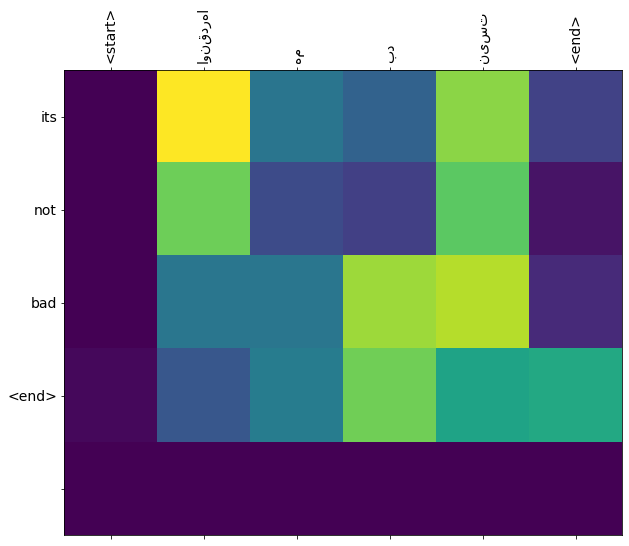

In [32]:
translate("اونقدرها هم بد نیست")